In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False) # force return nd.array
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
# sci-kit learn datasets have similar structure and keys
# DESCR, data (one row per instance + one column per feature), and target are normal keys
X, y = mnist["data"], mnist["target"]
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

X.shape = (70000, 784)
y.shape = (70000,)


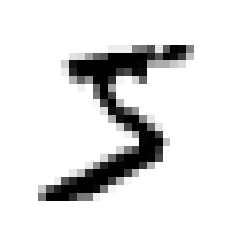

Label = 5


In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# Label is string so cast to number
y = y.astype(np.uint8)
print(f"Label = {y[0]}")

In [19]:
# always create test set and set it aside before inspecting the data closely
# dataset is already shuffled so no need to train_test_split
split_idx = 60000
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## Training a Binary Classifier

In [20]:
# make binary labels
y_train_5 = (y_train == 5)
y_test_t = (y_test == 5)

In [27]:
# good place to start is Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [28]:
# see if it works
print(f"sgd_classify[{5}] = {sgd_classifier.predict([some_digit])}")

sgd_classify[5] = [ True]


### Performance Measures

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

# write custom cross-val class to get idea of how it works
def cross_val(sgd_class, 
              X_train, 
              y_train, 
              n_splits=3, 
              random_state=42) -> None:
    """
    Performs cross-validation
    Inputs: 1. SGD Classifier
            2. training set X_train
            3. labels for training set
    """
    skfold = StratifiedKFold(shuffle=True, n_splits=n_splits, random_state=random_state)

    for train_idx, test_idx in skfold.split(X_train, y_train):
        clone_sgd = clone(sgd_class)

        X_train_folds = X_train[train_idx]
        y_train_folds = y_train[train_idx]
        X_test_fold = X_train[test_idx]
        y_test_fold = y_train[test_idx]

        clone_sgd.fit(X_train_folds, y_train_folds)
        y_pred = clone_sgd.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(f"Score = {n_correct / len(y_test_fold)}")

In [34]:
cross_val(sgd_classifier, X_train, y_train_5)

Score = 0.9669
Score = 0.91625
Score = 0.96785


The accuracy looks good *but* this is because less than 10% of the samples are 5. So if the model just always predicts "no," then the model is still at minimum 90% accurate. 

A better metric is the *confusion matrix*.

### Confusion Matrix

General idea is to count the number of times instances of class A are classified as class B.

In [35]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

Each row of the confusion matrix represents an actual class while each column represents a predicted class. Confusion matrix = ([TN | FN], [FP | TP]).

### Precision and Recall (Sensitivity/True Positive Rate)

In [39]:
from sklearn.metrics import precision_score, recall_score

p_score = precision_score(y_train_5, y_train_predict)
r_score = recall_score(y_train_5, y_train_predict)

print(f"Precision = {p_score}")
print(f"Recall = {r_score}")

# combine precision and recall into one metric
# Harmonic mean = gives more weight to lower values
# to get a high score, both precision and recall need to be similar
from sklearn.metrics import f1_score
f1_score = f1_score(y_train_5, y_train_predict)
print(f"f1_score = {f1_score}")

Precision = 0.8370879772350012
Recall = 0.6511713705958311
f1_score = 0.7325171197343846


In [40]:
# increasing precision reduces recall

# scikit-learn does not allow to change decision function threshold directly but 
# we can make decisions from the score outputs with whatever threshhold we want
y_scores = sgd_classifier.decision_function([some_digit])
print(f"y_scores = {y_scores}")
threshold = 3000
y_predictions = y_scores > threshold
print(f"Predictions = {y_predictions}")


y_scores = [2164.22030239]
Predictions = [False]


In [64]:
# how do we decide which threshold to use?
# plot precision and recall against various thresholds and make tradeoff decisions
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5,
                             cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
p_s, r_s, th_s = precision_recall_curve(y_train_5, y_scores)

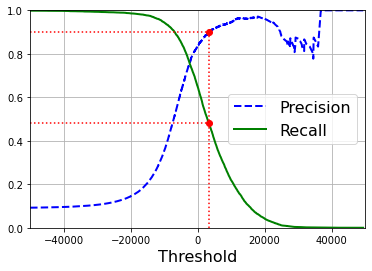

In [65]:
recall_90_precision = r_s[np.argmax(p_s >= 0.90)]
threshold_90_precision = th_s[np.argmax(p_s >= 0.90)]
    
def plot_prec_recall_vs_th(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])
    plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
    plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
    plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
    plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")
    plt.show()

plot_prec_recall_vs_th(p_s, r_s, th_s)

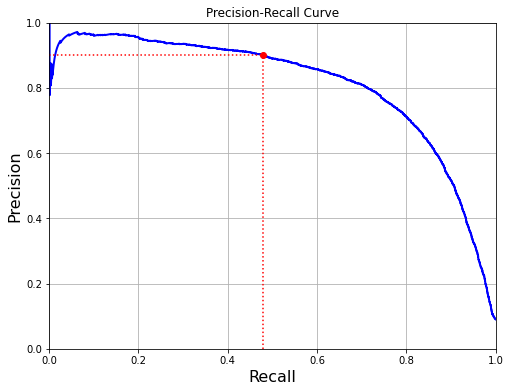

In [67]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(p_s, r_s)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.title("Precision-Recall Curve")
plt.show()

A very good PR curve should tend toward the top-right corner.

### ROC(*receiver operating characteristic*) Curve

Very common tool used with *binary* classifiers. Plots *true positive rate* against *false positive rate*.

In [68]:
from sklearn.metrics import roc_curve

f_pos, t_pos, th_s = roc_curve(y_train_5, y_scores)

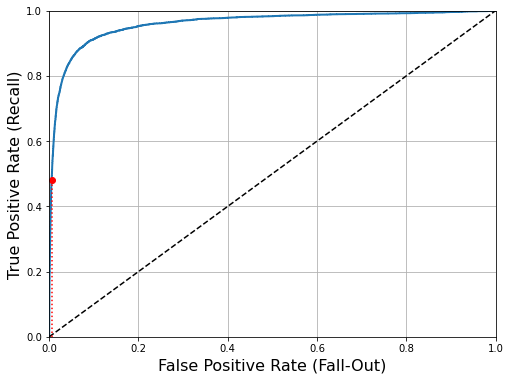

In [69]:
def plot_roc_curve(f_pos, t_pos, label=None):
    plt.plot(f_pos, t_pos, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(f_pos, t_pos)
f_90 = f_pos[np.argmax(t_pos >= recall_90_precision)]           # Not shown
plt.plot([f_90, f_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, f_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([f_90], [recall_90_precision], "ro")               # Not shown                                 # Not shown
plt.show()

In [70]:
# one method to compare classifiers is to measure AUC
# pure random has AUC = 0.5
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_train_5, y_scores)
print(f"auc_score = {auc_score}")

auc_score = 0.9604938554008616


When you care about **false positives MORE than false negatives**, you should use the **precision-recall curve**.

Train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to the `SGDClassifier`.

In [71]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_classifier, X_train, y_train_5, 
                                   cv=3, method="predict_proba")

In [73]:
y_scores_forest = y_probs_forest[:,1] # score = prob of positive class
f_pos_forest, t_pos_forest, th_forest = roc_curve(y_train_5, y_scores_forest)

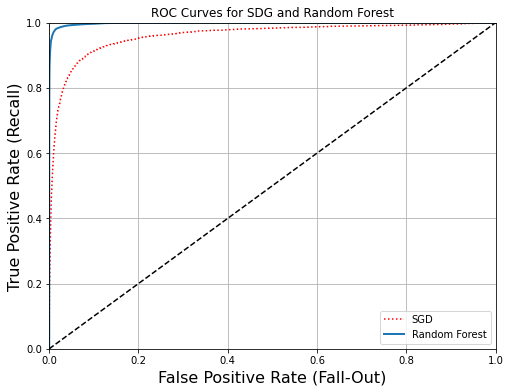

In [76]:
# plot the ROC curve for Random Forest Classifier 
plt.figure(figsize=(8, 6))   
plt.plot(f_pos, t_pos, "r:", label="SGD")
plot_roc_curve(f_pos_forest, t_pos_forest, "Random Forest")
plt.legend(loc="lower right")
plt.title("ROC Curves for SDG and Random Forest")
plt.show()

In [77]:
print(f"AUC for Random Forest = {roc_auc_score(y_train_5, y_scores_forest)}")

AUC for Random Forest = 0.9983436731328145


## Multiclass Classification

Two main types of algorithms:
1. One vs All (OvA): train multiple binary classifiers to classify one class type
2. One vs One (OvO): train a binary classifier for every pair of classes

This is good when an algo scales poorly with the size of the dataset i.e. a SVM. For most binary classification algorithms, OvA is preferred.

In [78]:
# scikit learn automatically detects when you try to use a binary classification
# problem for a multi-class classification task (auto run OvA)
# (except for SVM, in which OvO is run)

sgd_classifier.fit(X_train, y_train) # multi-class
sgd_classifier.predict([some_digit])

# under the hood, scikit learn trained 10 binary classifiers and got their 
# decision scores for the test image and returned class with highest score

array([3], dtype=uint8)

In [82]:
some_digit_scores = sgd_classifier.decision_function([some_digit])
target_classes = sgd_classifier.classes_
for i, score in zip(target_classes, some_digit_scores[0]):
    print(f"Score for {i} = {score}")

Score for 0 = -31893.030954190526
Score for 1 = -34419.69069632278
Score for 2 = -9530.639507393267
Score for 3 = 1823.7315403079076
Score for 4 = -22320.148228778264
Score for 5 = -1385.804788945628
Score for 6 = -26188.91070950851
Score for 7 = -16147.51323997278
Score for 8 = -4604.354912743626
Score for 9 = -12050.767298003786


In [83]:
# random forest classifiers inherently can do multiclass classification
forest_classifier.fit(X_train, y_train)
forest_classifier.predict([some_digit])

array([5], dtype=uint8)

In [84]:
# get the probabilities for each class
forest_classifier.predict_proba([some_digit]) # see 90% for 5

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [85]:
# evaluate the classifiers 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [87]:
# can use standardization to boost the scores 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [88]:
# analyze confusion matrix to analyze the types of errors model makes
y_train_pred = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


<Figure size 576x432 with 0 Axes>

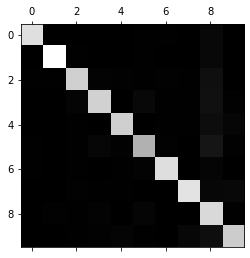

In [95]:
# above is a lot of numbers so visualize it instead 
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Can see that most of the classes are labeled correctly except a few being mis-labeled as 8. Can further analyze to see the error rates.

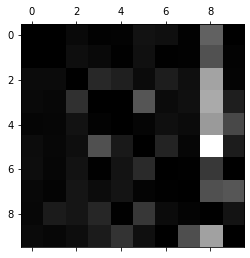

In [92]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_mx / row_sums

# fill in the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [96]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [97]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [99]:
# measure the F1 score of each label and then average all of these F1 scores
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) # takes too long to train omg...
f1_score(y_multilabel, y_train_knn_pred, average="macro")
# if you eant to give a label weight equal to its support (num_instances)
# then set average="weighted"

## Multi-output Classification

In [ ]:
# build a system to denoise
train_noise = np.random.randint(0, 100, size=(len(X_train), 784))
X_train_mod = X_train + train_noise
y_train_mod = X_train
 
test_noise = np.random.randint()
X_test_mod = X_test + test_noise
y_test_mod = X_test

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)